# Modeling and Simulation in Python

Chapter 6

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

from pandas import read_html

### Code from the previous chapter



In [2]:
filename = 'data/World_population_estimates.html'
tables = read_html(filename, header=0, index_col=0, decimal='M')
table2 = tables[2]
table2.columns = ['census', 'prb', 'un', 'maddison', 
                  'hyde', 'tanton', 'biraben', 'mj', 
                  'thomlinson', 'durand', 'clark']

In [3]:
un = table2.un / 1e9
un.head()

Year
1950    2.525149
1951    2.572851
1952    2.619292
1953    2.665865
1954    2.713172
Name: un, dtype: float64

In [4]:
census = table2.census / 1e9
census.head()

Year
1950    2.557629
1951    2.594940
1952    2.636772
1953    2.682053
1954    2.730228
Name: census, dtype: float64

In [5]:
t_0 = get_first_label(census)
t_end = get_last_label(census)
elapsed_time = t_end - t_0

p_0 = get_first_value(census)
p_end = get_last_value(census)
total_growth = p_end - p_0

annual_growth = total_growth / elapsed_time

0.07224800083333333

### System objects

We can rewrite the code from the previous chapter using system objects.

In [6]:
system = System(t_0=t_0, 
                t_end=t_end,
                p_0=p_0,
                annual_growth=annual_growth)

,values
t_0,1950.000000
t_end,2016.000000
p_0,2.557629
annual_growth,0.072248


And we can encapsulate the code that runs the model in a function.

In [7]:
def run_simulation1(system):
    """Runs the constant growth model.
    
    system: System object
    
    returns: TimeSeries
    """
    results = TimeSeries()
    results[system.t_0] = system.p_0
    
    for t in linrange(system.t_0, system.t_end):
        results[t+1] = results[t] + system.annual_growth
    
    return results

We can also encapsulate the code that plots the results.

In [8]:
def plot_results(census, un, timeseries, title):
    """Plot the estimates and the model.
    
    census: TimeSeries of population estimates
    un: TimeSeries of population estimates
    timeseries: TimeSeries of simulation results
    title: string
    """
    plot(census, ':', label='US Census')
    plot(un, '--', label='UN DESA')
    plot(timeseries, color='gray', label='model')
    
    decorate(xlabel='Year', 
             ylabel='World population (billion)',
             title=title)

Here's how we run it.

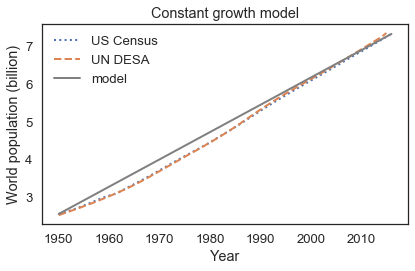

In [9]:
results = run_simulation1(system)
plot_results(census, un, results, 'Constant growth model')

## Proportional growth

Here's a more realistic model where the number of births and deaths is proportional to the current population.

In [10]:
def run_simulation2(system):
    """Run a model with proportional birth and death.
    
    system: System object
    
    returns: TimeSeries
    """
    results = TimeSeries()
    results[system.t_0] = system.p_0
    
    for t in linrange(system.t_0, system.t_end):
        births = system.birth_rate * results[t]
        deaths = system.death_rate * results[t]
        results[t+1] = results[t] + births - deaths
        
    return results

I picked a death rate that seemed reasonable and then adjusted the birth rate to fit the data.

In [11]:
system.death_rate = 0.01
system.birth_rate = 0.027

Here's what it looks like.

Saving figure to file figs/chap06-fig01.pdf


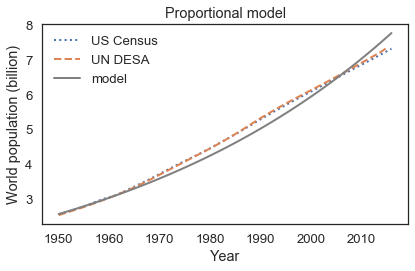

In [12]:
results = run_simulation2(system)
plot_results(census, un, results, 'Proportional model')
savefig('figs/chap06-fig01.pdf')

The model fits the data pretty well for the first 20 years, but not so well after that.

### Factoring out the update function

`run_simulation1` and `run_simulation2` are nearly identical except the body of the loop.  So we can factor that part out into a function.

In [13]:
def update_func1(pop, t, system):
    """Compute the population next year.
    
    pop: current population
    t: current year
    system: system object containing parameters of the model
    
    returns: population next year
    """
    births = system.birth_rate * pop
    deaths = system.death_rate * pop
    return pop + births - deaths

The name `update_func` refers to a function object.

In [14]:
update_func1

<function __main__.update_func1(pop, t, system)>

Which we can confirm by checking its type.

In [15]:
type(update_func1)

function

`run_simulation` takes the update function as a parameter and calls it just like any other function.

In [16]:
def run_simulation(system, update_func):
    """Simulate the system using any update function.
    
    system: System object
    update_func: function that computes the population next year
    
    returns: TimeSeries
    """
    results = TimeSeries()
    results[system.t_0] = system.p_0
    
    for t in linrange(system.t_0, system.t_end):
        results[t+1] = update_func(results[t], t, system)
        
    return results

Here's how we use it.

In [17]:
t_0 = get_first_label(census)
t_end = get_last_label(census)
p_0 = census[t_0]

system = System(t_0=t_0, 
                t_end=t_end,
                p_0=p_0,
                birth_rate=0.027,
                death_rate=0.01)

,values
t_0,1950.000000
t_end,2016.000000
p_0,2.557629
birth_rate,0.027000
death_rate,0.010000


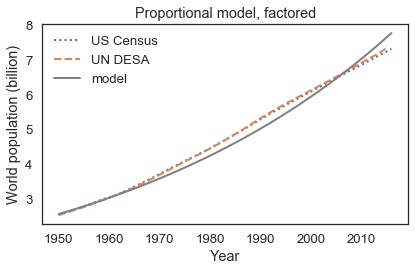

In [18]:
results = run_simulation(system, update_func1)
plot_results(census, un, results, 'Proportional model, factored')

Remember not to put parentheses after `update_func1`.  What happens if you try?

If you try to put parentheses after update_func1, you get a TypeError. 
TypeError: update_func1() missing 3 required positional arguments: 'pop', 't', and 'system'

**Exercise:** When you run `run_simulation`, it runs `update_func1` once for each year between `t_0` and `t_end`.  To see that for yourself, add a print statement at the beginning of `update_func1` that prints the values of `t` and `pop`, then run `run_simulation` again.

In [19]:
def update_func1(pop, t, system):
    """Compute the population next year.
    
    pop: current population
    t: current year
    system: system object containing parameters of the model
    
    returns: population next year
    """
    print(t, pop) # Print values of t and pop
    births = system.birth_rate * pop
    deaths = system.death_rate * pop
    return pop + births - deaths

In [20]:
def run_simulation(system, update_func):
    """Simulate the system using any update function.
    
    system: System object
    update_func: function that computes the population next year
    
    returns: TimeSeries
    """
    results = TimeSeries()
    results[system.t_0] = system.p_0
    
    for t in linrange(system.t_0, system.t_end):
        results[t+1] = update_func(results[t], t, system)
        
    return results

In [21]:
t_0 = get_first_label(census)
t_end = get_last_label(census)
p_0 = census[t_0]

system = System(t_0=t_0, 
                t_end=t_end,
                p_0=p_0,
                birth_rate=0.027,
                death_rate=0.01)

,values
t_0,1950.000000
t_end,2016.000000
p_0,2.557629
birth_rate,0.027000
death_rate,0.010000


1950 2.557628654
1951 2.601108341118
1952 2.645327182917006
1953 2.6902977450265952
1954 2.7360328066920476
1955 2.7825453644058125
1956 2.829848635600711
1957 2.8779560624059233
1958 2.926881315466824
1959 2.9766382978297603
1960 3.0272411488928666
1961 3.078704248424045
1962 3.131042220647254
1963 3.184269938398258
1964 3.2384025273510284
1965 3.293455370315996
1966 3.349444111611368
1967 3.406384661508761
1968 3.46429320075441
1969 3.523186185167235
1970 3.583080350315078
1971 3.6439927162704344
1972 3.7059405924470314
1973 3.768941582518631
1974 3.833013589421448
1975 3.8981748204416125
1976 3.9644437923891203
1977 4.031839336859735
1978 4.100380605586351
1979 4.170087075881319
1980 4.240978556171301
1981 4.313075191626214
1982 4.3863974698838595
1983 4.460966226871885
1984 4.536802652728707
1985 4.613928297825096
1986 4.692365078888122
1987 4.77213528522922
1988 4.8532615850781164
1989 4.935767032024445
1990 5.0196750715688605
1991 5.1050095477855315
1992 5.191794710097886
1993 5.

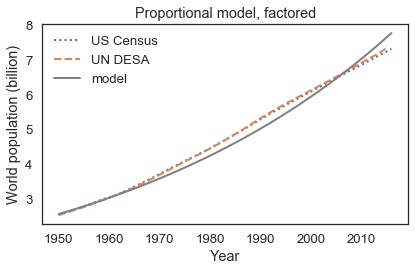

In [22]:
results = run_simulation(system, update_func1)
plot_results(census, un, results, 'Proportional model, factored')

As you can see above, when running the simulation you get a print out of all the values in addition to the plot.

### Combining birth and death

Since births and deaths get added up, we don't have to compute them separately.  We can combine the birth and death rates into a single net growth rate.

In [23]:
def update_func2(pop, t, system):
    """Compute the population next year.
    
    pop: current population
    t: current year
    system: system object containing parameters of the model
    
    returns: population next year
    """
    net_growth = system.alpha  * pop
    return pop + net_growth

Here's how it works:

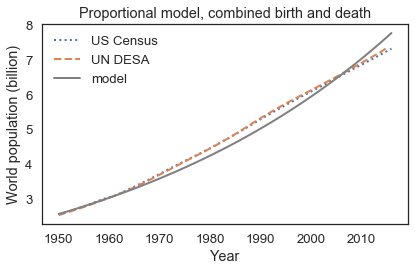

In [24]:
system.alpha = system.birth_rate - system.death_rate

results = run_simulation(system, update_func2)
plot_results(census, un, results, 'Proportional model, combined birth and death')

### Exercises

**Exercise:** Maybe the reason the proportional model doesn't work very well is that the growth rate, `alpha`, is changing over time.  So let's try a model with different growth rates before and after 1980 (as an arbitrary choice).

Write an update function that takes `pop`, `t`, and `system` as parameters.  The system object, `system`, should contain two parameters: the growth rate before 1980, `alpha1`, and the growth rate after 1980, `alpha2`.  It should use `t` to determine which growth rate to use.  Note: Don't forget the `return` statement.

Test your function by calling it directly, then pass it to `run_simulation`.  Plot the results.  Adjust the parameters `alpha1` and `alpha2` to fit the data as well as you can.



In [25]:
def update_func3(pop, t, system):
    """Compute the population next year.
    
    pop: current population
    t: current year
    system: system object containing parameters of the model
    
    returns: population next year
    """
    if t < 1980: # Checks if t is before 1980
        net_growth = system.alpha1 * pop # Calculate growth rate for years before 1980
    else:
        net_growth = system.alpha2 * pop # Calculate growth rate for years after 1980
    return pop + net_growth # Return the sum of pop and net growth

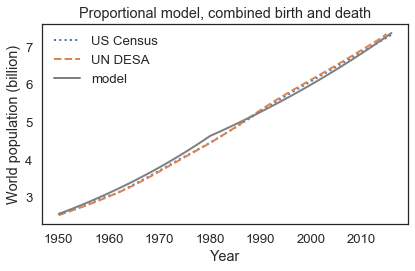

In [26]:
system.alpha1 = 0.02
system.alpha2 = 0.013
results = run_simulation(system, update_func3)
plot_results(census, un, results, 'Proportional model, combined birth and death')

To fit the data as best as possbile, I started with values of 0.5 for both alpha1 and alpha2. The plot was illegible so I reduced the values by 0.1 and plotted again. I kept reducing by 0.1 and when I reached 0.0, I went to 0.05 and repeated what I did. For alpha1 I kept reducing by 0.01 and when I reached 0.02 I was starting to get a model that fit the data. For alpha2 I had to keep trying and ended at 0.013 as the value that best fit the data. 